# This notebook feautres failed attempts to use an arrythmia classifier on the VitalDB database that was trained on MIT-BIH arrythmia dataset

In [ ]:
# Importing packages
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd
from pathlib import Path
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

In [ ]:
import numpy as np
from scipy.signal import medfilt, iirnotch, filtfilt, periodogram, butter, filtfilt

def global_baseline_removal(signal, fs, window_sec=1.5):
    kernel_size = int(window_sec * fs)
    if kernel_size % 2 == 0:
        kernel_size += 1
    baseline = medfilt(signal, kernel_size=kernel_size)
    return signal - baseline

def apply_notch_filter(signal, fs, freq=60, Q=30):
    w0 = freq / (fs / 2)
    b, a = iirnotch(w0, Q)
    return filtfilt(b, a, signal)

def compute_noise_metrics(window, fs):
    f, Pxx = periodogram(window, fs)
    power_total = np.sum(Pxx)
    power_bw = np.sum(Pxx[f < 0.5]) / power_total if power_total > 0 else 0
    power_emg = np.sum(Pxx[f > 30]) / power_total if power_total > 0 else 0
    return power_bw, power_emg

def robust_z(metric):
    median = np.median(metric)
    mad = np.median(np.abs(metric - median))
    mad_scaled = 1.4826 * mad if mad > 0 else 1  # avoid division by zero
    return (np.array(metric) - median) / mad_scaled

def overlap_add(windows, starts, signal_length, window_size):
    reconstructed = np.zeros(signal_length)
    counts = np.zeros(signal_length)
    for w, start in zip(windows, starts):
        end = start + window_size
        reconstructed[start:end] += w
        counts[start:end] += 1
    counts[counts == 0] = 1  # avoid division by zero
    return reconstructed / counts

def adaptive_denoise_signal(signal, fs):
    """
    Denoises a 1D ECG or PPG signal using:
    - Global baseline wander removal
    - Global notch filter
    - Local BW removal
    - Local EMG noise removal

    Returns:
    - Filtered signal of same length
    """

    # 1️⃣ Global Baseline Wander Removal
    signal_clean = global_baseline_removal(signal, fs)

    # 2️⃣ Global Notch Filter for PLI
    signal_clean = apply_notch_filter(signal_clean, fs)

    # 3️⃣ Local Baseline Wander Removal (8s windows, 2s overlap)
    window_bw_sec = 8
    overlap_bw_sec = 2
    win_bw_samples = int(window_bw_sec * fs)
    overlap_bw_samples = int(overlap_bw_sec * fs)
    stride_bw_samples = win_bw_samples - overlap_bw_samples

    windows_bw = []
    starts_bw = []
    for start in range(0, len(signal_clean) - win_bw_samples + 1, stride_bw_samples):
        end = start + win_bw_samples
        windows_bw.append(signal_clean[start:end])
        starts_bw.append(start)

    # Compute BW noise metrics
    power_bw_list = []
    for w in windows_bw:
        power_bw, _ = compute_noise_metrics(w, fs)
        power_bw_list.append(power_bw)

    z_bw = robust_z(power_bw_list)

    # Apply local BW filtering
    filtered_windows_bw = []
    for i, w in enumerate(windows_bw):
        w_filtered = w.copy()
        if z_bw[i] > 2:
            w_filtered = global_baseline_removal(w_filtered, fs, window_sec=1.0)
        filtered_windows_bw.append(w_filtered)

    # Reconstruct signal after BW step
    signal_bw_clean = overlap_add(filtered_windows_bw, starts_bw, len(signal_clean), win_bw_samples)

    # 4️⃣ Local EMG Noise Removal (4s windows, 1s overlap)
    window_emg_sec = 4
    overlap_emg_sec = 1
    win_emg_samples = int(window_emg_sec * fs)
    overlap_emg_samples = int(overlap_emg_sec * fs)
    stride_emg_samples = win_emg_samples - overlap_emg_samples

    windows_emg = []
    starts_emg = []
    for start in range(0, len(signal_bw_clean) - win_emg_samples + 1, stride_emg_samples):
        end = start + win_emg_samples
        windows_emg.append(signal_bw_clean[start:end])
        starts_emg.append(start)

    # Compute EMG noise metrics
    power_emg_list = []
    for w in windows_emg:
        _, power_emg = compute_noise_metrics(w, fs)
        power_emg_list.append(power_emg)

    z_emg = robust_z(power_emg_list)

    # Apply local EMG filtering
    filtered_windows_emg = []
    for i, w in enumerate(windows_emg):
        w_filtered = w.copy()
        if z_emg[i] > 2:
            b, a = butter(4, 40 / (fs / 2), btype='low')
            w_filtered = filtfilt(b, a, w_filtered)
        filtered_windows_emg.append(w_filtered)

    # Reconstruct final signal
    filtered_signal = overlap_add(filtered_windows_emg, starts_emg, len(signal_bw_clean), win_emg_samples)

    return filtered_signal


In [ ]:
import numpy as np
import pandas as pd
import vitaldb
from scipy.signal import resample_poly, find_peaks
from tqdm import tqdm

def snip_edges(signal, percent):
    samples_to_remove = int(percent * len(signal))
    return signal[samples_to_remove:-samples_to_remove]

def normalize_signal(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    if std == 0:
        std = 1
    return (signal - mean) / std

def estimate_heart_rate(ecg_signal, fs, num_peaks=10):
    """
    Roughly estimate HR by detecting the first few R-peaks.
    Restrict HR to 40-200 bpm range.
    """
    distance = int(0.4 * fs)  # Minimum distance between R-peaks (~150 bpm max)
    peaks, _ = find_peaks(ecg_signal, distance=distance, prominence=np.std(ecg_signal))
    if len(peaks) >= num_peaks + 1:
        rr_intervals = np.diff(peaks[:num_peaks+1]) / fs
        avg_rr = np.mean(rr_intervals)
        if avg_rr > 0:
            hr = 60 / avg_rr
            if 40 <= hr <= 200:
                return hr
    return np.nan  # fallback if not enough peaks found or HR unreasonable

def preprocess_vitaldb_subjects(
    subject_ids,
    fs=500,
    target_fs=256,
    min_duration_min=8,
    snip_percent=0.10,
    adaptive_denoise_fn=None
):
    """
    Preprocesses VitalDB ECG and PPG data:
    - Snip edges
    - Denoise
    - Normalize
    - Estimate HR
    """
    min_samples = min_duration_min * 60 * target_fs
    processed_data = []

    print(f"🚑 Preprocessing {len(subject_ids)} cases from VitalDB...")

    for cid in tqdm(subject_ids):
        try:
            # Load ECG and PPG
            vals = vitaldb.load_case(cid, ['ECG_II', 'PLETH'], 1/fs)
            ecg = vals[:, 0]
            ppg = vals[:, 1]
            valid = ~np.isnan(ecg) & ~np.isnan(ppg)
            ecg = ecg[valid]
            ppg = ppg[valid]

            # Skip if too short
            if len(ecg) < fs * 60:
                print(f"⚠️ Case {cid} skipped: too short ({len(ecg)/fs:.1f} sec).")
                continue

            # Downsample to target_fs
            if fs != target_fs:
                ecg = resample_poly(ecg, target_fs, fs)
                ppg = resample_poly(ppg, target_fs, fs)
                effective_fs = target_fs
            else:
                effective_fs = fs

            # Snip first and last 10%
            ecg_snipped = snip_edges(ecg, snip_percent)
            ppg_snipped = snip_edges(ppg, snip_percent)

            # Check if snipped data is at least 8 minutes
            if len(ecg_snipped) < min_samples:
                print(f"⚠️ Case {cid} skipped: too short after snipping ({len(ecg_snipped)/effective_fs:.1f} sec).")
                continue

            # Apply denoising pipeline
            if adaptive_denoise_fn is None:
                raise ValueError("Please provide adaptive_denoise_fn to the function.")
            ecg_denoised = adaptive_denoise_fn(ecg_snipped, effective_fs)
            ppg_denoised = adaptive_denoise_fn(ppg_snipped, effective_fs)

            # Normalize
            ecg_norm = normalize_signal(ecg_denoised)
            ppg_norm = normalize_signal(ppg_denoised)

            # Estimate heart rate
            heart_rate = estimate_heart_rate(ecg_denoised, effective_fs)

            # Store processed data
            processed_data.append({
                'CaseID': cid,
                'ECG': ecg_norm,
                'PPG': ppg_norm,
                'Fs': effective_fs,
                'HR': heart_rate
            })

            print(f"✅ Case {cid} processed successfully. Estimated HR: {heart_rate:.1f} bpm")

        except Exception as e:
            print(f"⚠️ Case {cid} skipped due to error: {e}")

    print(f"✅ Completed preprocessing {len(processed_data)} cases.")
    return processed_data



In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, TensorDataset
from scipy.signal import resample_poly

from models.ecg2ppg_model import ECG2PPGps
from models.ecg2ppg_LSTM_after import ECG2PPGpsThenLSTM
from utils.eval_metrics import compute_dtw, compute_pearson, compute_rmse

# --- Assume adaptive_denoise_signal is imported ---
# from your_filtering_module import adaptive_denoise_signal

def load_and_preprocess_synth_data(hr, fs, target_fs, adaptive_denoise_fn, min_duration_min=8):
    file_path = f"synth_csv/synthSubHR{hr}.csv"
    if not os.path.exists(file_path):
        print(f"⚠️ File not found: {file_path}")
        return None, None, None

    df = pd.read_csv(file_path)
    df = df[['Time [s]', ' II', ' PLETH']]
    ecg = df[' II'].to_numpy()
    ppg = df[' PLETH'].to_numpy()

    time_col = df['Time [s]'].to_numpy()
    fs_inferred = 1 / np.median(np.diff(time_col))
    fs_inferred_rounded = int(round(fs_inferred))

    if fs_inferred_rounded != target_fs:
        ecg = resample_poly(ecg, target_fs, fs_inferred_rounded)
        ppg = resample_poly(ppg, target_fs, fs_inferred_rounded)
        effective_fs = target_fs
    else:
        effective_fs = fs_inferred_rounded

    min_samples = int(min_duration_min * 60 * effective_fs)
    if len(ecg) < min_samples:
        print(f"⚠️ Not enough samples after downsampling for HR {hr}. Skipping.")
        return None, None, None
    ecg = ecg[:min_samples]
    ppg = ppg[:min_samples]

    ecg = adaptive_denoise_fn(ecg, effective_fs)
    ppg = adaptive_denoise_fn(ppg, effective_fs)

    ecg = (ecg - np.mean(ecg)) / np.std(ecg)
    ppg = (ppg - np.mean(ppg)) / np.std(ppg)

    return ecg, ppg, effective_fs

def train_and_save_pretrained_models(
    hr_buckets,
    target_fs=256,
    adaptive_denoise_fn=None,
    output_folder_base="pretrain_models",
    window_length_sec=8,
    overlap_sec=2,
    max_epochs=20,
    batch_size=128
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    for hr in hr_buckets:
        print(f"\n❤️ Processing HR bucket: {hr} bpm")

        ecg, ppg, effective_fs = load_and_preprocess_synth_data(
            hr, fs=target_fs, target_fs=target_fs,
            adaptive_denoise_fn=adaptive_denoise_fn
        )
        if ecg is None or ppg is None or effective_fs is None:
            continue

        window_samples = int(window_length_sec * effective_fs)
        overlap_samples = int(overlap_sec * effective_fs)
        stride_samples = window_samples - overlap_samples

        def create_windows(signal):
            return np.array([
                signal[start:start+window_samples]
                for start in range(0, len(signal) - window_samples + 1, stride_samples)
            ])

        ecg_windows = create_windows(ecg)
        ppg_windows = create_windows(ppg)

        num_windows = len(ecg_windows)
        if num_windows < 1:
            print(f"⚠️ Not enough windows for HR {hr}. Skipping.")
            continue

        train_dataset = TensorDataset(
            torch.tensor(ppg_windows, dtype=torch.float32).unsqueeze(1),
            torch.tensor(ecg_windows, dtype=torch.float32).unsqueeze(1)
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for model_name, model_class in [
            ("ECG2PPGps", ECG2PPGps),
            ("ECG2PPGpsThenLSTM", ECG2PPGpsThenLSTM)
        ]:
            print(f"🔵 Training model: {model_name} for HR {hr} bpm")

            model = model_class(in_channels=1, out_channels=1).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            loss_fn = ECG2PPGps_loss

            model.train()
            progress_bar = tqdm(
                total=max_epochs * len(train_loader),
                desc=f"HR {hr} - {model_name}",
                unit="batch"
            )

            for epoch in range(max_epochs):
                epoch_loss = 0.0
                for input_batch, target_batch in train_loader:
                    input_batch = input_batch.to(device)
                    target_batch = target_batch.to(device)

                    optimizer.zero_grad()
                    output_batch = model(input_batch)
                    loss = loss_fn(output_batch, target_batch)
                    loss.backward()
                    optimizer.step()

                    epoch_loss += loss.item()
                    progress_bar.update(1)

            progress_bar.close()

            save_folder = os.path.join(output_folder_base, f"HR_{hr}")
            os.makedirs(save_folder, exist_ok=True)
            save_path = os.path.join(save_folder, f"{model_name}_pretrain.pth")
            torch.save(model.state_dict(), save_path)
            print(f"💾 Model saved: {save_path}")

    print("✅ All HR buckets processed and models saved.")


In [128]:
processed_data = preprocess_vitaldb_subjects(
    subject_ids=range(1, 100),
    fs=500,
    target_fs=256,
    min_duration_min=20,
    adaptive_denoise_fn=adaptive_denoise_signal)

🚑 Preprocessing 99 cases from VitalDB...


  1%|▊                                                                                  | 1/99 [00:01<02:44,  1.67s/it]

⚠️ Case 1 skipped due to error: can only concatenate list (not "int") to list


  2%|█▋                                                                                 | 2/99 [00:03<03:08,  1.94s/it]

⚠️ Case 2 skipped due to error: can only concatenate list (not "int") to list


  3%|██▌                                                                                | 3/99 [00:04<02:15,  1.41s/it]

⚠️ Case 3 skipped due to error: can only concatenate list (not "int") to list


  4%|███▎                                                                               | 4/99 [00:07<03:03,  1.94s/it]

⚠️ Case 4 skipped due to error: can only concatenate list (not "int") to list


  5%|████▏                                                                              | 5/99 [00:10<03:32,  2.26s/it]

⚠️ Case 5 skipped due to error: can only concatenate list (not "int") to list


  6%|█████                                                                              | 6/99 [00:10<02:44,  1.77s/it]

⚠️ Case 6 skipped due to error: can only concatenate list (not "int") to list


  7%|█████▊                                                                             | 7/99 [00:13<02:54,  1.90s/it]

⚠️ Case 7 skipped due to error: can only concatenate list (not "int") to list


  8%|██████▋                                                                            | 8/99 [00:14<02:25,  1.60s/it]

⚠️ Case 8 skipped due to error: can only concatenate list (not "int") to list


  9%|███████▌                                                                           | 9/99 [00:14<02:00,  1.34s/it]

⚠️ Case 9 skipped due to error: can only concatenate list (not "int") to list


 10%|████████▎                                                                         | 10/99 [00:17<02:35,  1.75s/it]

⚠️ Case 10 skipped due to error: can only concatenate list (not "int") to list


 11%|█████████                                                                         | 11/99 [00:18<02:09,  1.48s/it]

⚠️ Case 11 skipped due to error: can only concatenate list (not "int") to list


 12%|█████████▉                                                                        | 12/99 [00:19<02:06,  1.46s/it]

⚠️ Case 12 skipped: too short (0.0 sec).


 13%|██████████▊                                                                       | 13/99 [00:21<02:06,  1.47s/it]

⚠️ Case 13 skipped due to error: can only concatenate list (not "int") to list


 14%|███████████▌                                                                      | 14/99 [00:22<01:45,  1.24s/it]

⚠️ Case 14 skipped due to error: can only concatenate list (not "int") to list


 15%|████████████▍                                                                     | 15/99 [00:22<01:29,  1.06s/it]

⚠️ Case 15 skipped due to error: can only concatenate list (not "int") to list


 16%|█████████████▎                                                                    | 16/99 [00:24<01:45,  1.27s/it]

⚠️ Case 16 skipped due to error: can only concatenate list (not "int") to list


 17%|██████████████                                                                    | 17/99 [00:27<02:18,  1.69s/it]

⚠️ Case 17 skipped due to error: can only concatenate list (not "int") to list


 18%|██████████████▉                                                                   | 18/99 [00:27<01:56,  1.43s/it]

⚠️ Case 18 skipped due to error: can only concatenate list (not "int") to list


 19%|███████████████▋                                                                  | 19/99 [00:31<02:43,  2.04s/it]

⚠️ Case 19 skipped due to error: can only concatenate list (not "int") to list


 20%|████████████████▌                                                                 | 20/99 [00:34<03:14,  2.46s/it]

⚠️ Case 20 skipped due to error: can only concatenate list (not "int") to list


 21%|█████████████████▍                                                                | 21/99 [00:36<02:53,  2.23s/it]

⚠️ Case 21 skipped due to error: can only concatenate list (not "int") to list


 22%|██████████████████▏                                                               | 22/99 [00:38<02:46,  2.16s/it]

⚠️ Case 22 skipped due to error: can only concatenate list (not "int") to list


 23%|███████████████████                                                               | 23/99 [00:39<02:06,  1.67s/it]

⚠️ Case 23 skipped due to error: can only concatenate list (not "int") to list


 24%|███████████████████▉                                                              | 24/99 [00:39<01:48,  1.45s/it]

⚠️ Case 24 skipped due to error: can only concatenate list (not "int") to list


 25%|████████████████████▋                                                             | 25/99 [00:41<01:59,  1.62s/it]

⚠️ Case 25 skipped due to error: can only concatenate list (not "int") to list


 26%|█████████████████████▌                                                            | 26/99 [00:43<01:55,  1.58s/it]

⚠️ Case 26 skipped due to error: can only concatenate list (not "int") to list


 27%|██████████████████████▎                                                           | 27/99 [00:45<02:10,  1.81s/it]

⚠️ Case 27 skipped due to error: can only concatenate list (not "int") to list


 28%|███████████████████████▏                                                          | 28/99 [00:49<02:46,  2.34s/it]

⚠️ Case 28 skipped due to error: can only concatenate list (not "int") to list


 29%|████████████████████████                                                          | 29/99 [00:52<02:53,  2.49s/it]

⚠️ Case 29 skipped due to error: can only concatenate list (not "int") to list


 30%|████████████████████████▊                                                         | 30/99 [00:53<02:33,  2.23s/it]

⚠️ Case 30 skipped due to error: can only concatenate list (not "int") to list


 31%|█████████████████████████▋                                                        | 31/99 [00:55<02:15,  2.00s/it]

⚠️ Case 31 skipped due to error: can only concatenate list (not "int") to list


 32%|██████████████████████████▌                                                       | 32/99 [00:55<01:47,  1.61s/it]

⚠️ Case 32 skipped due to error: can only concatenate list (not "int") to list


 33%|███████████████████████████▎                                                      | 33/99 [00:56<01:33,  1.42s/it]

⚠️ Case 33 skipped due to error: can only concatenate list (not "int") to list


 34%|████████████████████████████▏                                                     | 34/99 [01:00<02:04,  1.92s/it]

⚠️ Case 34 skipped due to error: can only concatenate list (not "int") to list


 35%|████████████████████████████▉                                                     | 35/99 [01:01<01:44,  1.63s/it]

⚠️ Case 35 skipped due to error: can only concatenate list (not "int") to list


 36%|█████████████████████████████▊                                                    | 36/99 [01:01<01:27,  1.39s/it]

⚠️ Case 36 skipped due to error: can only concatenate list (not "int") to list


 37%|██████████████████████████████▋                                                   | 37/99 [01:03<01:31,  1.47s/it]

⚠️ Case 37 skipped due to error: can only concatenate list (not "int") to list


 38%|███████████████████████████████▍                                                  | 38/99 [01:05<01:34,  1.55s/it]

⚠️ Case 38 skipped due to error: can only concatenate list (not "int") to list


 39%|████████████████████████████████▎                                                 | 39/99 [01:05<01:16,  1.28s/it]

⚠️ Case 39 skipped due to error: can only concatenate list (not "int") to list


 40%|█████████████████████████████████▏                                                | 40/99 [01:06<01:12,  1.23s/it]

⚠️ Case 40 skipped due to error: can only concatenate list (not "int") to list


 41%|█████████████████████████████████▉                                                | 41/99 [01:08<01:18,  1.36s/it]

⚠️ Case 41 skipped due to error: can only concatenate list (not "int") to list


 42%|██████████████████████████████████▊                                               | 42/99 [01:10<01:28,  1.56s/it]

⚠️ Case 42 skipped due to error: can only concatenate list (not "int") to list


 43%|███████████████████████████████████▌                                              | 43/99 [01:12<01:35,  1.71s/it]

⚠️ Case 43 skipped due to error: can only concatenate list (not "int") to list


 44%|████████████████████████████████████▍                                             | 44/99 [01:14<01:38,  1.79s/it]

⚠️ Case 44 skipped due to error: can only concatenate list (not "int") to list


 45%|█████████████████████████████████████▎                                            | 45/99 [01:15<01:23,  1.55s/it]

⚠️ Case 45 skipped due to error: can only concatenate list (not "int") to list


 46%|██████████████████████████████████████                                            | 46/99 [01:17<01:20,  1.52s/it]

⚠️ Case 46 skipped due to error: can only concatenate list (not "int") to list


 47%|██████████████████████████████████████▉                                           | 47/99 [01:18<01:11,  1.38s/it]

⚠️ Case 47 skipped due to error: can only concatenate list (not "int") to list


 48%|███████████████████████████████████████▊                                          | 48/99 [01:19<01:16,  1.50s/it]

⚠️ Case 48 skipped due to error: can only concatenate list (not "int") to list


 49%|████████████████████████████████████████▌                                         | 49/99 [01:21<01:18,  1.56s/it]

⚠️ Case 49 skipped due to error: can only concatenate list (not "int") to list


 51%|█████████████████████████████████████████▍                                        | 50/99 [01:23<01:24,  1.73s/it]

⚠️ Case 50 skipped due to error: can only concatenate list (not "int") to list


 52%|██████████████████████████████████████████▏                                       | 51/99 [01:25<01:16,  1.60s/it]

⚠️ Case 51 skipped due to error: can only concatenate list (not "int") to list


 53%|███████████████████████████████████████████                                       | 52/99 [01:27<01:23,  1.77s/it]

⚠️ Case 52 skipped due to error: can only concatenate list (not "int") to list


 54%|███████████████████████████████████████████▉                                      | 53/99 [01:28<01:09,  1.50s/it]

⚠️ Case 53 skipped: too short (0.0 sec).


 55%|████████████████████████████████████████████▋                                     | 54/99 [01:30<01:16,  1.71s/it]

⚠️ Case 54 skipped due to error: can only concatenate list (not "int") to list


 56%|█████████████████████████████████████████████▌                                    | 55/99 [01:31<01:09,  1.57s/it]

⚠️ Case 55 skipped: too short (0.0 sec).


 57%|██████████████████████████████████████████████▍                                   | 56/99 [01:33<01:07,  1.58s/it]

⚠️ Case 56 skipped: too short (0.0 sec).


 58%|███████████████████████████████████████████████▏                                  | 57/99 [01:34<01:05,  1.57s/it]

⚠️ Case 57 skipped due to error: can only concatenate list (not "int") to list


 59%|████████████████████████████████████████████████                                  | 58/99 [01:36<01:10,  1.71s/it]

⚠️ Case 58 skipped due to error: can only concatenate list (not "int") to list


 60%|████████████████████████████████████████████████▊                                 | 59/99 [01:37<00:55,  1.39s/it]

⚠️ Case 59 skipped due to error: can only concatenate list (not "int") to list


 61%|█████████████████████████████████████████████████▋                                | 60/99 [01:39<01:04,  1.65s/it]

⚠️ Case 60 skipped due to error: can only concatenate list (not "int") to list


 62%|██████████████████████████████████████████████████▌                               | 61/99 [01:41<00:58,  1.55s/it]

⚠️ Case 61 skipped due to error: can only concatenate list (not "int") to list


 63%|███████████████████████████████████████████████████▎                              | 62/99 [01:42<00:56,  1.54s/it]

⚠️ Case 62 skipped due to error: can only concatenate list (not "int") to list


 64%|████████████████████████████████████████████████████▏                             | 63/99 [01:43<00:49,  1.36s/it]

⚠️ Case 63 skipped due to error: can only concatenate list (not "int") to list


 65%|█████████████████████████████████████████████████████                             | 64/99 [01:45<00:53,  1.53s/it]

⚠️ Case 64 skipped due to error: can only concatenate list (not "int") to list


 66%|█████████████████████████████████████████████████████▊                            | 65/99 [01:47<00:53,  1.58s/it]

⚠️ Case 65 skipped due to error: can only concatenate list (not "int") to list


 67%|██████████████████████████████████████████████████████▋                           | 66/99 [01:48<00:49,  1.49s/it]

⚠️ Case 66 skipped due to error: can only concatenate list (not "int") to list


 68%|███████████████████████████████████████████████████████▍                          | 67/99 [01:49<00:48,  1.53s/it]

⚠️ Case 67 skipped due to error: can only concatenate list (not "int") to list


 69%|████████████████████████████████████████████████████████▎                         | 68/99 [01:51<00:45,  1.46s/it]

⚠️ Case 68 skipped due to error: can only concatenate list (not "int") to list


 70%|█████████████████████████████████████████████████████████▏                        | 69/99 [01:52<00:40,  1.36s/it]

⚠️ Case 69 skipped due to error: can only concatenate list (not "int") to list


 71%|█████████████████████████████████████████████████████████▉                        | 70/99 [01:54<00:44,  1.53s/it]

⚠️ Case 70 skipped due to error: can only concatenate list (not "int") to list


 72%|██████████████████████████████████████████████████████████▊                       | 71/99 [01:55<00:38,  1.39s/it]

⚠️ Case 71 skipped due to error: can only concatenate list (not "int") to list


 73%|███████████████████████████████████████████████████████████▋                      | 72/99 [01:56<00:36,  1.35s/it]

⚠️ Case 72 skipped due to error: can only concatenate list (not "int") to list


 74%|████████████████████████████████████████████████████████████▍                     | 73/99 [01:57<00:31,  1.19s/it]

⚠️ Case 73 skipped due to error: can only concatenate list (not "int") to list


 75%|█████████████████████████████████████████████████████████████▎                    | 74/99 [01:59<00:39,  1.58s/it]

⚠️ Case 74 skipped due to error: can only concatenate list (not "int") to list


 76%|██████████████████████████████████████████████████████████████                    | 75/99 [02:03<00:49,  2.08s/it]

⚠️ Case 75 skipped due to error: can only concatenate list (not "int") to list
⚠️ Case 76 skipped due to error: too many indices for array: array is 1-dimensional, but 2 were indexed


 78%|███████████████████████████████████████████████████████████████▊                  | 77/99 [02:04<00:32,  1.48s/it]

⚠️ Case 77 skipped due to error: can only concatenate list (not "int") to list


 79%|████████████████████████████████████████████████████████████████▌                 | 78/99 [02:05<00:27,  1.30s/it]

⚠️ Case 78 skipped due to error: can only concatenate list (not "int") to list


 80%|█████████████████████████████████████████████████████████████████▍                | 79/99 [02:08<00:33,  1.68s/it]

⚠️ Case 79 skipped due to error: can only concatenate list (not "int") to list


 81%|██████████████████████████████████████████████████████████████████▎               | 80/99 [02:08<00:26,  1.39s/it]

⚠️ Case 80 skipped due to error: can only concatenate list (not "int") to list


 82%|███████████████████████████████████████████████████████████████████               | 81/99 [02:10<00:27,  1.51s/it]

⚠️ Case 81 skipped due to error: can only concatenate list (not "int") to list


 83%|███████████████████████████████████████████████████████████████████▉              | 82/99 [02:11<00:21,  1.28s/it]

⚠️ Case 82 skipped due to error: can only concatenate list (not "int") to list


 84%|████████████████████████████████████████████████████████████████████▋             | 83/99 [02:14<00:26,  1.67s/it]

⚠️ Case 83 skipped due to error: can only concatenate list (not "int") to list


 85%|█████████████████████████████████████████████████████████████████████▌            | 84/99 [02:16<00:28,  1.90s/it]

⚠️ Case 84 skipped due to error: can only concatenate list (not "int") to list


 86%|██████████████████████████████████████████████████████████████████████▍           | 85/99 [02:17<00:22,  1.57s/it]

⚠️ Case 85 skipped due to error: can only concatenate list (not "int") to list


 87%|███████████████████████████████████████████████████████████████████████▏          | 86/99 [02:18<00:18,  1.39s/it]

⚠️ Case 86 skipped due to error: can only concatenate list (not "int") to list


 88%|████████████████████████████████████████████████████████████████████████          | 87/99 [02:19<00:17,  1.45s/it]

⚠️ Case 87 skipped due to error: can only concatenate list (not "int") to list


 89%|████████████████████████████████████████████████████████████████████████▉         | 88/99 [02:21<00:15,  1.39s/it]

⚠️ Case 88 skipped due to error: can only concatenate list (not "int") to list


 90%|█████████████████████████████████████████████████████████████████████████▋        | 89/99 [02:23<00:17,  1.74s/it]

⚠️ Case 89 skipped due to error: can only concatenate list (not "int") to list


 91%|██████████████████████████████████████████████████████████████████████████▌       | 90/99 [02:24<00:13,  1.49s/it]

⚠️ Case 90 skipped due to error: can only concatenate list (not "int") to list


 92%|███████████████████████████████████████████████████████████████████████████▎      | 91/99 [02:26<00:12,  1.61s/it]

⚠️ Case 91 skipped due to error: can only concatenate list (not "int") to list


 93%|████████████████████████████████████████████████████████████████████████████▏     | 92/99 [02:27<00:09,  1.36s/it]

⚠️ Case 92 skipped due to error: can only concatenate list (not "int") to list


 94%|█████████████████████████████████████████████████████████████████████████████     | 93/99 [02:27<00:06,  1.16s/it]

⚠️ Case 93 skipped due to error: can only concatenate list (not "int") to list


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 94/99 [02:31<00:09,  1.82s/it]

⚠️ Case 94 skipped due to error: can only concatenate list (not "int") to list


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 95/99 [02:32<00:06,  1.51s/it]

⚠️ Case 95 skipped due to error: can only concatenate list (not "int") to list


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 96/99 [02:36<00:07,  2.50s/it]

⚠️ Case 96 skipped due to error: can only concatenate list (not "int") to list


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 97/99 [02:39<00:04,  2.39s/it]

⚠️ Case 97 skipped due to error: can only concatenate list (not "int") to list


 99%|█████████████████████████████████████████████████████████████████████████████████▏| 98/99 [02:40<00:01,  2.00s/it]

⚠️ Case 98 skipped due to error: can only concatenate list (not "int") to list


100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [02:40<00:00,  1.63s/it]

⚠️ Case 99 skipped due to error: can only concatenate list (not "int") to list
✅ Completed preprocessing 0 cases.


In [6]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def plot_first_peaks(processed_data, num_peaks=5):
    """
    Plot the ECG signal with the first few R-peaks and show the estimated HR.
    """
    for data in processed_data[:20]:
        cid = data['CaseID']
        ecg = data['ECG']
        fs = data['Fs']
        hr = data['HR']

        # Find R-peaks (reuse the estimate_heart_rate logic)
        distance = int(0.4 * fs)  # Allow max ~150 bpm
        peaks, _ = find_peaks(ecg, distance=distance, prominence=np.std(ecg))
        first_peaks = peaks[:num_peaks] if len(peaks) >= num_peaks else peaks

        # Plot ECG segment with R-peaks
        time = np.arange(len(ecg)) / fs
        plt.figure(figsize=(12, 4))
        plt.plot(time[1:1000], ecg[1:1000], label='ECG Signal')
        plt.plot(time[first_peaks], ecg[first_peaks], 'ro', label='Detected Peaks')
        plt.title(f"Subject {cid} - Estimated HR: {hr:.1f} bpm")
        plt.xlabel("Time (s)")
        plt.ylabel("Normalized ECG")
        plt.legend()
        plt.grid()
        plt.show()

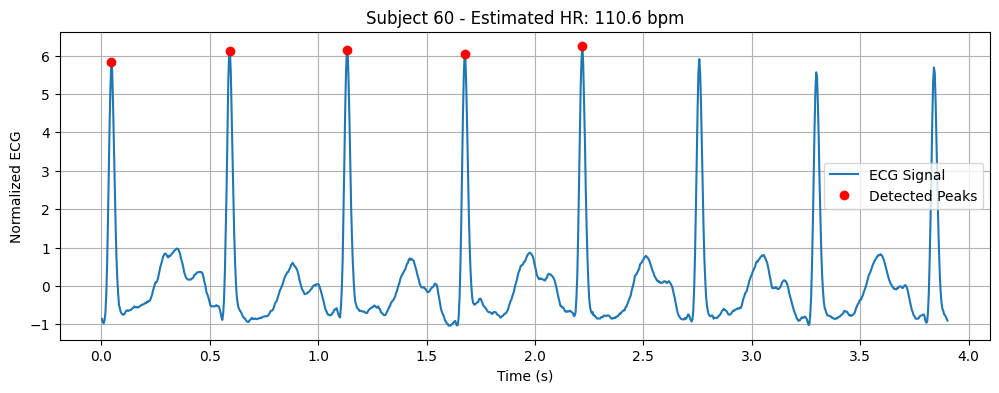

In [7]:
plot_first_peaks(processed_data, num_peaks=5)

In [13]:
import os
import numpy as np
import neurokit2 as nk

# Set output folder
output_dir = "rpeak_annotations"
os.makedirs(output_dir, exist_ok=True)

# Process each subject
for subject in processed_data:
    case_id = subject['CaseID']
    ecg_signal = subject['ECG']
    fs = subject['Fs']

    # File paths
    rpeaks_npy_path = os.path.join(output_dir, f"{case_id}_rpeaks.npy")
    rpeaks_csv_path = os.path.join(output_dir, f"{case_id}_rpeaks.csv")

    # Skip if both files exist
    if os.path.exists(rpeaks_npy_path) and os.path.exists(rpeaks_csv_path):
        print(f"⏭️ R-peaks already exist for Case {case_id}, skipping.")
        continue

    try:
        # Detect R-peaks
        _, info = nk.ecg_process(ecg_signal, sampling_rate=fs)
        r_peaks = info["ECG_R_Peaks"]

        # Save results
        np.save(rpeaks_npy_path, r_peaks)
        np.savetxt(rpeaks_csv_path, r_peaks, delimiter=",", fmt="%d")

        print(f"✅ Saved R-peaks for Case {case_id} ({len(r_peaks)} peaks)")

    except Exception as e:
        print(f"⚠️ Failed to process Case {case_id}: {e}")


✅ Saved R-peaks for Case 60 (17193 peaks)


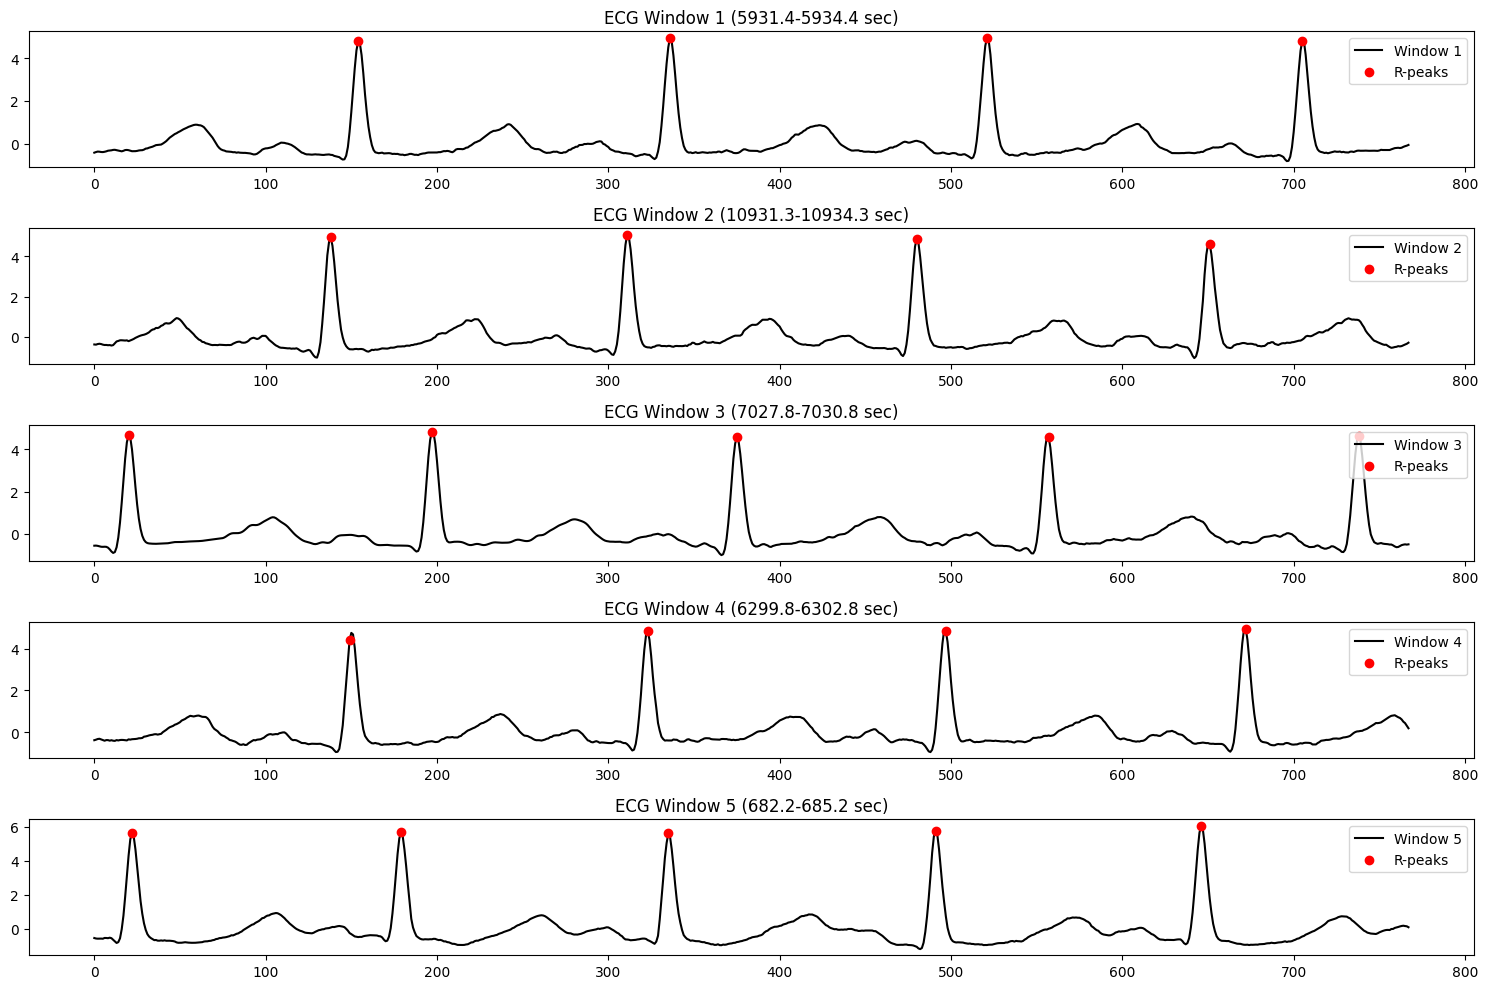

In [14]:
import random
# Choose random windows
fs = 256
window_size = 3 * fs  # 3-second window
num_windows = 5
total_length = len(ecg_signal)
starts = random.sample(range(0, total_length - window_size), num_windows)

# Plot
plt.figure(figsize=(15, 10))
for i, start in enumerate(starts):
    end = start + window_size
    window = ecg_signal[start:end]

    # Get R-peaks within window
    r_in_window = [r for r in r_peaks if start <= r < end]
    r_local = [r - start for r in r_in_window]

    # Plot window
    plt.subplot(num_windows, 1, i+1)
    plt.plot(window, label=f"Window {i+1}", color='black')
    plt.scatter(r_local, window[r_local], color='red', label="R-peaks", zorder=5)
    plt.legend(loc="upper right")
    plt.title(f"ECG Window {i+1} ({start/fs:.1f}-{end/fs:.1f} sec)")

plt.tight_layout()
plt.show()

✅ Extracted 17193 ECG windows of size 214


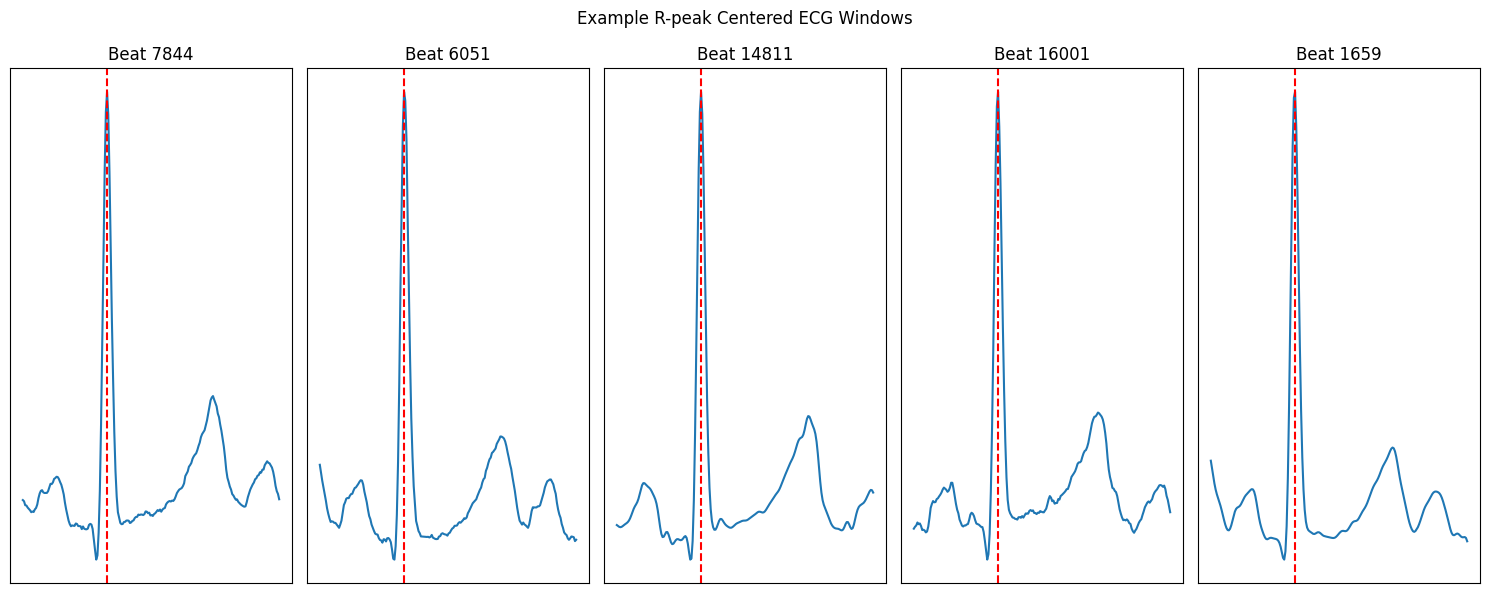

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt

WINDOW_BEFORE = 70
WINDOW_AFTER = 143
WINDOW_SIZE = WINDOW_BEFORE + WINDOW_AFTER + 1  # 214

ecg_windows = []
case_id = processed_data[0]['CaseID']
ecg_signal = processed_data[0]['ECG']
fs = processed_data[0]['Fs']

# Load R-peaks
rpeaks_path = os.path.join("rpeak_annotations", f"{case_id}_rpeaks.npy")
r_peaks = np.load(rpeaks_path)

# Window extraction
for peak in r_peaks:
    start = peak - WINDOW_BEFORE
    end = peak + WINDOW_AFTER + 1
    if start >= 0 and end <= len(ecg_signal):
        window = ecg_signal[start:end]
        ecg_windows.append(window)

print(f"✅ Extracted {len(ecg_windows)} ECG windows of size {WINDOW_SIZE}")

# Plot a few examples
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
for i, idx in enumerate(random.sample(range(len(ecg_windows)), min(5, len(ecg_windows)))):
    plt.subplot(1, 5, i+1)
    plt.plot(ecg_windows[idx])
    plt.axvline(WINDOW_BEFORE, color='red', linestyle='--', label='R-peak')
    plt.title(f"Beat {idx}")
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Example R-peak Centered ECG Windows")
plt.tight_layout()
plt.show()


In [16]:
import os
import numpy as np
from tqdm import tqdm

def extract_and_save_ecg_windows(processed_data, rpeak_dir='rpeak_annotations', output_dir='ecg_windows',
                                 before=70, after=143):
    os.makedirs(output_dir, exist_ok=True)
    total_saved = 0

    for subject in tqdm(processed_data):
        case_id = subject['CaseID']
        ecg_signal = subject['ECG']
        rpeak_path = os.path.join(rpeak_dir, f"{case_id}_rpeaks.npy")

        if not os.path.exists(rpeak_path):
            print(f"⚠️ Skipping {case_id}: R-peaks file not found.")
            continue

        r_peaks = np.load(rpeak_path)
        windows = []

        for peak in r_peaks:
            start = peak - before
            end = peak + after + 1
            if start >= 0 and end <= len(ecg_signal):
                window = ecg_signal[start:end]
                windows.append(window)

        if windows:
            windows_array = np.stack(windows)
            save_path = os.path.join(output_dir, f"{case_id}_windows.npy")
            np.save(save_path, windows_array)
            print(f"✅ Saved {len(windows)} windows for case {case_id} to {save_path}")
            total_saved += len(windows)
        else:
            print(f"⚠️ No valid windows extracted for case {case_id}")

    print(f"\n✅ Total ECG windows saved: {total_saved}")

# Example usage
extract_and_save_ecg_windows(processed_data)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.73it/s]

✅ Saved 17193 windows for case 60 to ecg_windows\60_windows.npy

✅ Total ECG windows saved: 17193


Class distribution: Counter({np.int64(0): 12760, np.int64(3): 4381, np.int64(1): 50, np.int64(4): 1, np.int64(2): 1})


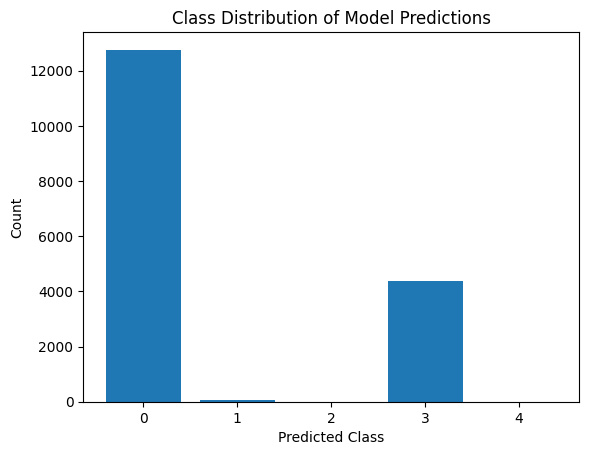

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from arythmia_models import build_model  # Make sure path is correct

# Load ECG windows
windows = np.load('ecg_windows/60_windows.npy')
X = torch.tensor(windows, dtype=torch.float32).unsqueeze(1)  # (N, 1, 213)

# Build and load model
model = build_model(input_size=213, num_classes=5)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

checkpoint = torch.load('./mit-bih-arrhythmia-database-1.0.0/pytorch_weights.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Run predictions
X = X.to(device)
with torch.no_grad():
    outputs = model(X)
    predicted_classes = torch.argmax(outputs, dim=1).cpu().numpy()

# Show class distribution
counts = Counter(predicted_classes)
print("Class distribution:", counts)

# Plot
plt.bar(counts.keys(), counts.values())
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Class Distribution of Model Predictions")
plt.show()


In [107]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset
from pathlib import Path
from scipy.signal import find_peaks

from models.ecg2ppg_LSTM_after import ECG2PPGpsThenLSTM  # adjust path if needed

# ==== CONFIGURATION ====
cid = 96  # subject ID
model_variant = "ECG2PPGpsThenLSTM_no_pretrain"
fs = 256
window_before = 70
window_after = 143
window_size = window_before + window_after
window_sec = 8
stride_sec = 2
output_folder = "subject_models"
rpeak_folder = Path("r_peaks")
window_folder = Path("ecg_windows_beat_aligned")
rpeak_folder.mkdir(parents=True, exist_ok=True)
window_folder.mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

✅ Using device: cuda


In [108]:
# ==== HELPER FUNCTIONS ====
def normalize_signal(signal):
    signal = np.array(signal)
    
    # Remove DC offset (mean)
    signal = signal - np.mean(signal)
    
    # Normalize by standard deviation
    std = np.std(signal)
    if std > 1e-6:
        signal = signal / std

    return signal


def window_signal(signal, window_samples, stride_samples):
    return np.array([
        signal[start:start + window_samples]
        for start in range(0, len(signal) - window_samples + 1, stride_samples)
    ])


In [109]:
# ==== LOAD DATA ====
ppg = processed_data[0]['PPG']
ecg_filtered = processed_data[0]['ECG']
length = len(ecg_filtered)

#reconstructed_norm = (reconstructed - np.mean(reconstructed))/(np.std(reconstructed))
#ecg_filtered_norm = normalize_signal(ecg_filtered)

In [110]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

from models.ecg2ppg_LSTM_after import ECG2PPGpsThenLSTM
from models.ecg2ppg_model import ECG2PPGps_loss
from utils.eval_metrics import compute_dtw, compute_pearson, compute_rmse

def normalize_signal(signal):
    signal = np.array(signal)
    signal = signal - np.mean(signal)
    std = np.std(signal)
    if std > 1e-6:
        signal = signal / std
    return signal

def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def train_lstm_model_for_subject(
    data,
    output_folder="subject_models",
    window_length_sec=8,
    overlap_sec=6,
    max_epochs=500,
    batch_size=128,
    seed=42
):
    os.makedirs(output_folder, exist_ok=True)
    set_random_seed(seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"✅ Using device: {device}")

    try:
        cid = data['CaseID']
        ecg = normalize_signal(data['ECG'])
        ppg = normalize_signal(data['PPG'])
        fs = data['Fs']
        hr = int(data['HR'])

        print(f"\n🔵 Training Subject {cid} with HR {hr} bpm")

        window_samples = int(window_length_sec * fs)
        overlap_samples = int(overlap_sec * fs)
        stride_samples = window_samples - overlap_samples

        def create_windows(signal):
            return np.array([
                signal[start:start+window_samples]
                for start in range(0, len(signal) - window_samples + 1, stride_samples)
            ])

        ecg_windows = create_windows(ecg)
        ppg_windows = create_windows(ppg)

        if len(ecg_windows) < 1:
            print(f"⚠️ Skipping Subject {cid}: Not enough windows.")
            return

        win_per_min = fs * 60 / stride_samples
        train_wins = int(win_per_min * 8)
        test_wins = int(win_per_min * 2)
        val_wins = int(win_per_min * 2)

        train_idx = slice(0, train_wins)
        test_idx = slice(train_wins, train_wins+test_wins)
        val_idx = slice(train_wins+test_wins, train_wins+test_wins+val_wins)

        splits = {
            "train": (ppg_windows[train_idx], ecg_windows[train_idx]),
            "test": (ppg_windows[test_idx], ecg_windows[test_idx]),
            "val": (ppg_windows[val_idx], ecg_windows[val_idx])
        }

        model = ECG2PPGpsThenLSTM(in_channels=1, out_channels=1).to(device)
        model_label = f"ECG2PPGpsThenLSTM_no_pretrain"
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=0.1)
        loss_fn = ECG2PPGps_loss

        train_ppg, train_ecg = splits["train"]
        train_dataset = TensorDataset(
            torch.tensor(train_ppg, dtype=torch.float32).unsqueeze(1),
            torch.tensor(train_ecg, dtype=torch.float32).unsqueeze(1)
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        total_steps = max_epochs * len(train_loader)
        progress_bar = tqdm(
            total=total_steps,
            desc=f"Subject {cid} - {model_label}",
            unit="batch",
            leave=True,
            position=0
        )

        model.train()
        for epoch in range(max_epochs):
            for input_batch, target_batch in train_loader:
                input_batch = input_batch.to(device)
                target_batch = target_batch.to(device)

                optimizer.zero_grad()
                output_batch = model(input_batch)
                loss = loss_fn(output_batch, target_batch)
                loss.backward()
                optimizer.step()

                progress_bar.update(1)
            scheduler.step()
        progress_bar.close()

        save_path = os.path.join(output_folder, f"subject_{cid}_{model_label}_model.pth")
        torch.save(model.state_dict(), save_path)
        print(f"💾 Model saved: {save_path}")

        model.eval()
        metrics = {"Window": [], "Split": [], "DTW": [], "Pearson": [], "RMSE": []}
        with torch.no_grad():
            for split_name, (ppg_win, ecg_win) in splits.items():
                dataset = TensorDataset(
                    torch.tensor(ppg_win, dtype=torch.float32).unsqueeze(1),
                    torch.tensor(ecg_win, dtype=torch.float32).unsqueeze(1)
                )
                loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
                all_outputs, all_targets = [], []

                for input_batch, target_batch in loader:
                    input_batch = input_batch.to(device)
                    output_batch = model(input_batch)
                    all_outputs.append(output_batch.squeeze(1).cpu().numpy())
                    all_targets.append(target_batch.squeeze(1).cpu().numpy())

                outputs = np.vstack(all_outputs)
                targets = np.vstack(all_targets)

                for i in range(len(outputs)):
                    metrics["Window"].append(i)
                    metrics["Split"].append(split_name)
                    metrics["DTW"].append(compute_dtw(targets[i], outputs[i]))
                    metrics["Pearson"].append(compute_pearson(targets[i], outputs[i]))
                    metrics["RMSE"].append(compute_rmse(targets[i], outputs[i]))

        eval_df = pd.DataFrame(metrics)
        eval_path = os.path.join(output_folder, f"subject_{cid}_{model_label}_evaluation.csv")
        eval_df.to_csv(eval_path, index=False)
        print(f"💾 Evaluation saved: {eval_path}")

    except Exception as e:
        print(f"❌ Error training subject: {e}")


In [111]:
train_lstm_model_for_subject(processed_data[0])  # or whichever subject dict you want to train

✅ Using device: cuda

🔵 Training Subject 96 with HR 83 bpm


Subject 96 - ECG2PPGpsThenLSTM_no_pretrain: 100%|███████████████████████████████| 1000/1000 [01:39<00:00, 10.06batch/s]


💾 Model saved: subject_models\subject_96_ECG2PPGpsThenLSTM_no_pretrain_model.pth
💾 Evaluation saved: subject_models\subject_96_ECG2PPGpsThenLSTM_no_pretrain_evaluation.csv


In [112]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from models.ecg2ppg_LSTM_after import ECG2PPGpsThenLSTM

cid = 96
model_variant = "ECG2PPGpsThenLSTM_no_pretrain"
output_folder = "subject_models"
fs = 256
window_sec = 8
stride_sec = 2

# Load your processed signals
case = next(d for d in processed_data if d["CaseID"] == cid)
ppg = case["PPG"]
ecg = case["ECG"]

# --- Create sliding windows of PPG ---
window_samples = int(window_sec * fs)
stride_samples = int(stride_sec * fs)
def window_signal(signal, win, stride):
    return np.array([
        signal[i:i+win] for i in range(0, len(signal) - win + 1, stride)
    ])
ppg_windows = window_signal(ppg, window_samples, stride_samples)

# --- Load trained model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = f"{output_folder}/subject_{cid}_{model_variant}_model.pth"
model = ECG2PPGpsThenLSTM(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# --- Reconstruct ECG ---
reconstructed = np.zeros_like(ecg)
counts = np.zeros_like(ecg)
dataset = TensorDataset(torch.tensor(ppg_windows, dtype=torch.float32).unsqueeze(1))
loader = DataLoader(dataset, batch_size=128, shuffle=False)

start_idx = 0
with torch.no_grad():
    for batch in loader:
        inputs = batch[0].to(device)
        outputs = model(inputs).squeeze(1).cpu().numpy()
        for j, out in enumerate(outputs):
            idx = start_idx + j * stride_samples
            if idx + window_samples <= len(ecg):
                reconstructed[idx:idx + window_samples] += out
                counts[idx:idx + window_samples] += 1
        start_idx += len(outputs) * stride_samples

counts[counts == 0] = 1
reconstructed /= counts

# --- Normalize for plotting ---
def normalize_signal(signal):
    signal = np.asarray(signal)
    signal = signal - np.mean(signal)
    std = np.std(signal)
    if std > 1e-6:
        signal = signal / std
    return signal

reconstructed_norm = normalize_signal(reconstructed)
ecg_norm = normalize_signal(ecg)

# --- Save (optional, for reuse) ---
np.save(f"reconstructed_ecg_{cid}_{model_variant}.npy", reconstructed_norm)
np.save(f"true_ecg_{cid}.npy", ecg_norm)


🚑 Preprocessing 1 cases from VitalDB...


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.06s/it]

✅ Case 60 processed successfully. Estimated HR: 110.6 bpm
✅ Completed preprocessing 1 cases.


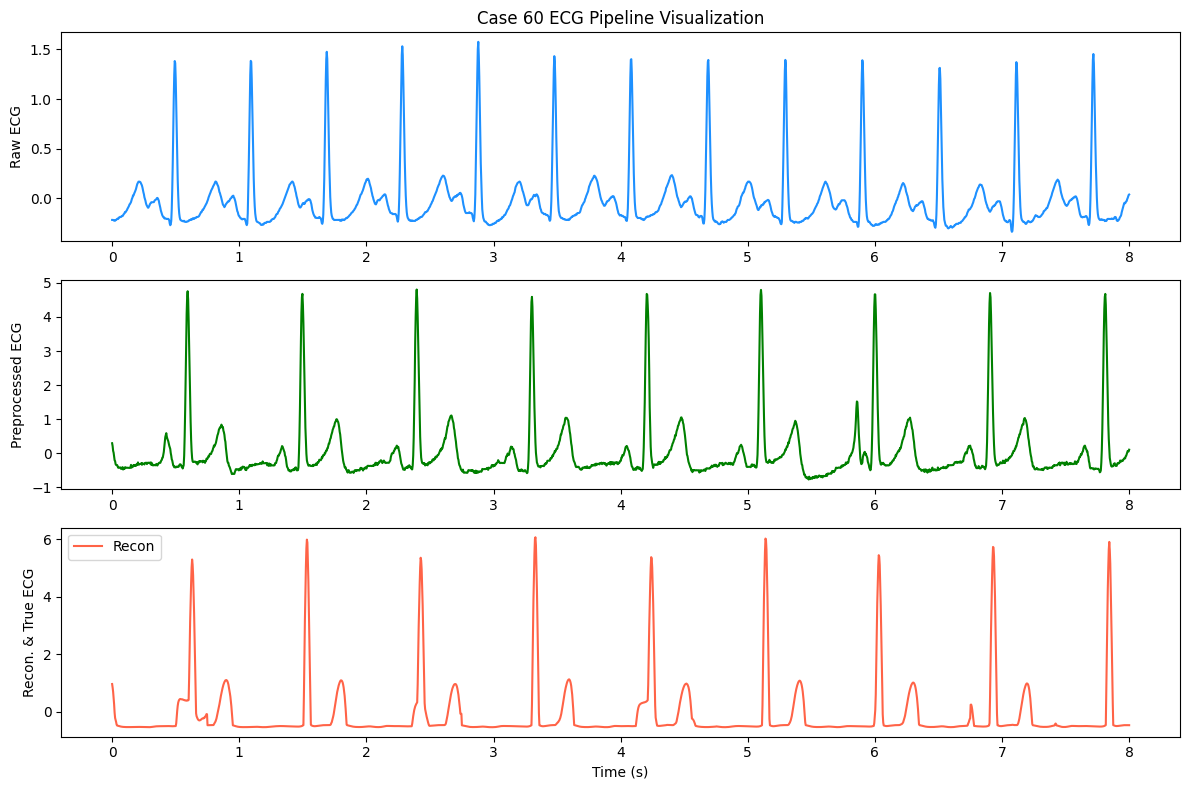

In [119]:
import matplotlib.pyplot as plt
import vitaldb
from scipy.signal import resample_poly
cid = 60

# --- Load Raw ECG ---
vals = vitaldb.load_case(cid, ['ECG_II', 'PLETH'], 1/500)
raw_ecg_full = vals[:, 0]           # index 0 is ECG_II
raw_ecg = resample_poly(raw_ecg_full, 256, 500)
raw_ecg = snip_edges(raw_ecg, 0.1)  # align with your preprocessed data

# --- Get window/segment ---
fs = 256
t_start = 540 * fs
t_len = 8 * fs
seg = slice(t_start, t_start + t_len)

# Align all signals: If your preprocessed signal is lagged (e.g. by 192 samples), shift it
lag = 192  # samples, adjust if different in your setup!
seg_proc = slice(t_start - lag, t_start - lag + t_len)

plt.figure(figsize=(12, 8))

# 1. Raw ECG (from VitalDB)
plt.subplot(3, 1, 1)
plt.plot(np.linspace(0, t_len/fs, t_len), raw_ecg[seg], color='dodgerblue')
plt.ylabel("Raw ECG")
plt.title(f"Case {cid} ECG Pipeline Visualization")

# 2. Preprocessed ECG (your pipeline)
plt.subplot(3, 1, 2)
plt.plot(np.linspace(0, t_len/fs, t_len), case["ECG"][seg_proc], color='green')
plt.ylabel("Preprocessed ECG")

# 3. Reconstructed ECG (model output)
plt.subplot(3, 1, 3)
plt.plot(np.linspace(0, t_len/fs, t_len), reconstructed_norm[seg_proc], color='tomato', label='Recon')
#plt.plot(np.linspace(0, t_len/fs, t_len), ecg_norm[seg_proc], color='black', alpha=0.5, label='True')
plt.ylabel("Recon. & True ECG")
plt.xlabel("Time (s)")
plt.legend()

plt.tight_layout()
plt.show()


In [106]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from models.ecg2ppg_LSTM_after import ECG2PPGpsThenLSTM
from models.ecg2ppg import ECG2PPGps

# === Configuration ===
cid = 60  # Subject ID
fs = 256
window_sec = 8
stride_sec = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_variant = "ECG2PPGps"
output_folder = "subject_models"

# === Normalization function ===
def normalize_signal(signal):
    signal = np.asarray(signal)
    signal = signal - np.mean(signal)
    std = np.std(signal)
    if std > 1e-6:
        signal = signal / std
    return signal

# === Load and normalize full subject signals ===
subject_data = next(d for d in processed_data if d["CaseID"] == cid)
ppg = normalize_signal(subject_data["PPG"])
ecg = normalize_signal(subject_data["ECG"])

# === Create sliding windows ===
window_samples = int(window_sec * fs)
stride_samples = int(stride_sec * fs)

def window_signal(signal, win, stride):
    return np.array([
        signal[i:i+win] for i in range(0, len(signal) - win + 1, stride)
    ])

ppg_windows = window_signal(ppg, window_samples, stride_samples)

# === Load trained model ===
model_path = os.path.join(output_folder, f"subject_{cid}_{model_variant}_model.pth")
model = ECG2PPGpsThenLSTM(in_channels=1, out_channels=1).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# === Run reconstruction ===
reconstructed = np.zeros_like(ecg)
counts = np.zeros_like(ecg)
dataset = TensorDataset(torch.tensor(ppg_windows, dtype=torch.float32).unsqueeze(1))
loader = DataLoader(dataset, batch_size=128, shuffle=False)

start_idx = 0
with torch.no_grad():
    for batch in loader:
        inputs = batch[0].to(device)
        outputs = model(inputs).squeeze(1).cpu().numpy()
        for j, out in enumerate(outputs):
            idx = start_idx + j * stride_samples
            if idx + window_samples <= len(ecg):
                reconstructed[idx:idx + window_samples] += out
                counts[idx:idx + window_samples] += 1
        start_idx += len(outputs) * stride_samples

# === Finalize reconstruction ===
counts[counts == 0] = 1
reconstructed /= counts

# === Normalize both signals ===
reconstructed_norm = normalize_signal(reconstructed)
ecg_norm = normalize_signal(ecg)

# === Save results ===
np.save(f"reconstructed_ecg_{cid}_{model_variant}.npy", reconstructed_norm)
np.save(f"true_ecg_{cid}.npy", ecg_norm)

print("✅ Reconstruction and saving completed.")


ImportError: cannot import name 'ECG2PPGps' from 'models.ecg2ppg_LSTM_after' (C:\Users\yair9\Masters\3360209 - dl for physio signals\PPG-to-ECG-\models\ecg2ppg_LSTM_after.py)

In [14]:
import matplotlib.pyplot as plt

fs = 256
start_times = [520, 560, 620]  # seconds
duration = 4  # seconds

for start_time in start_times:
    start_idx = int(start_time * fs)
    end_idx = start_idx + int(duration * fs)
    t = np.arange(start_idx, end_idx) / fs

    plt.figure(figsize=(12, 4))
    plt.plot(t, ecg_norm[start_idx:end_idx], label="True ECG", linewidth=1.5)
    plt.plot(t, reconstructed_norm[start_idx:end_idx], label="Reconstructed ECG", linestyle='--')
    plt.axhline(0, color='gray', linestyle=':')
    plt.title(f"ECG Comparison at {start_time}-{start_time+duration}s")
    plt.xlabel("Time (s)")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


NameError: name 'ecg_norm' is not defined

<Figure size 1200x400 with 0 Axes>

✅ Loaded 17195 beats of shape 213


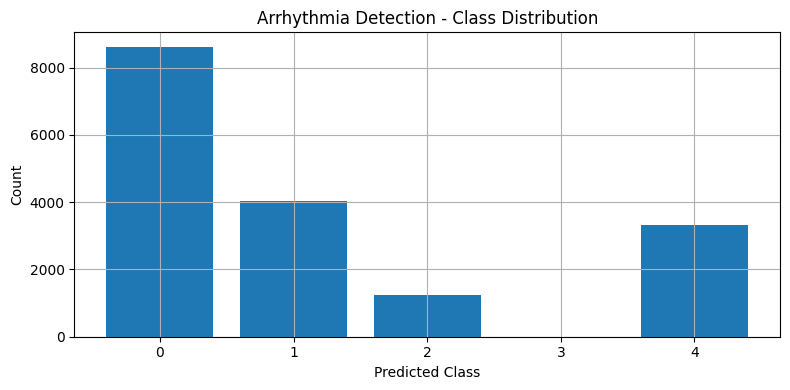

In [105]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from arythmia_models import build_model  # Assumes your classification model builder is here
import torch.nn.functional as F

# === Config ===
cid = 60
input_folder = "ecg_windows_beat_aligned"
model_path = './mit-bih-arrhythmia-database-1.0.0/pytorch_weights.pth'  # adjust path if needed
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Load Beat-Aligned Windows ===
beat_file = os.path.join(input_folder, f"{cid}_reconstructed_beats.npy")
beats = np.load(beat_file)
print(f"✅ Loaded {beats.shape[0]} beats of shape {beats.shape[1]}")

# === Prepare Dataset ===
beats_tensor = torch.tensor(beats, dtype=torch.float32).unsqueeze(1)  # shape (N, 1, L)
dataset = TensorDataset(beats_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=False)

# === Load Classification Model ===
model = build_model(input_size=beats.shape[1], num_classes=5)  # Adjust num_classes if needed
checkpoint = torch.load(model_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)
model.eval()

# === Run Inference ===
all_preds = []
with torch.no_grad():
    for (batch,) in loader:
        batch = batch.to(device)
        logits = model(batch)
        preds = torch.argmax(F.softmax(logits, dim=1), dim=1)
        all_preds.extend(preds.cpu().numpy())

all_preds = np.array(all_preds)

# === Class Distribution Plot ===
unique, counts = np.unique(all_preds, return_counts=True)
plt.figure(figsize=(8, 4))
plt.bar(unique, counts)
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.title("Arrhythmia Detection - Class Distribution")
plt.grid(True)
plt.tight_layout()
plt.show()


In [124]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from models.ecg2ppg_LSTM_after import ECG2PPGpsThenLSTM
from utils.eval_metrics import compute_dtw, compute_pearson, compute_rmse

MODEL_FOLDER = "subject_models"
MODEL_TYPE = "ECG2PPGpsThenLSTM_no_pretrain"
RESULTS_CSV = "reconstruction_metrics_all_cids.csv"
FS = 256
WINDOW_SEC = 8
STRIDE_SEC = 2


In [126]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from models.ecg2ppg_LSTM_after import ECG2PPGpsThenLSTM
from utils.eval_metrics import compute_dtw, compute_pearson, compute_rmse

MODEL_FOLDER = "subject_models"
MODEL_TYPE = "ECG2PPGpsThenLSTM_no_pretrain"
RESULTS_CSV = "reconstruction_metrics_all_cids.csv"
FS = 256
WINDOW_SEC = 8
STRIDE_SEC = 2

# --- Your normalization ---
def normalize_signal(signal):
    signal = np.asarray(signal)
    signal = signal - np.mean(signal)
    std = np.std(signal)
    if std > 1e-6:
        signal = signal / std
    return signal

# --- Your overlap-add for stitching ---
def overlap_add(windows, stride, signal_length, window_size):
    reconstructed = np.zeros(signal_length)
    counts = np.zeros(signal_length)
    for i, w in enumerate(windows):
        start = i * stride
        end = start + window_size
        reconstructed[start:end] += w
        counts[start:end] += 1
    counts[counts == 0] = 1  # avoid division by zero
    return reconstructed / counts

# --- Get processed case ---
def get_processed_case(cid):
    # Option 1: if in processed_data list:
    case = next((d for d in processed_data if d["CaseID"] == cid), None)
    return case

# --- Main loop ---
metrics = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for cid in range(1, 101):
    model_path = os.path.join(MODEL_FOLDER, f"subject_{cid}_{MODEL_TYPE}_model.pth")
    if not os.path.exists(model_path):
        print(f"Skipping CID {cid}: model not found.")
        continue

    # Get processed case
    case = get_processed_case(cid)
    if case is None:
        print(f"Skipping CID {cid}: processed data not found.")
        continue

    # Prepare data
    ppg = normalize_signal(case["PPG"])
    ecg = normalize_signal(case["ECG"])
    fs = case["Fs"]

    # Make windows
    window_samples = int(WINDOW_SEC * fs)
    stride_samples = int(STRIDE_SEC * fs)
    ppg_windows = np.array([
        ppg[i:i+window_samples] for i in range(0, len(ppg) - window_samples + 1, stride_samples)
    ])
    ecg_windows = np.array([
        ecg[i:i+window_samples] for i in range(0, len(ecg) - window_samples + 1, stride_samples)
    ])

    # Load model
    model = ECG2PPGpsThenLSTM(in_channels=1, out_channels=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Reconstruct
    recon_windows = []
    loader = DataLoader(TensorDataset(torch.tensor(ppg_windows, dtype=torch.float32).unsqueeze(1)), batch_size=128)
    with torch.no_grad():
        for (batch,) in loader:
            batch = batch.to(device)
            output = model(batch)
            recon_windows.append(output.squeeze(1).cpu().numpy())
    recon_windows = np.vstack(recon_windows)

    # --- STITCH BACK ---
    recon_stitched = overlap_add(recon_windows, stride_samples, len(ecg), window_samples)
    recon_stitched = normalize_signal(recon_stitched)
    ecg_norm = normalize_signal(ecg)

    # --- Window again (for fair metrics, same as above) ---
    recon_metrics_windows = np.array([
        recon_stitched[i:i+window_samples] for i in range(0, len(recon_stitched) - window_samples + 1, stride_samples)
    ])
    ecg_metrics_windows = np.array([
        ecg_norm[i:i+window_samples] for i in range(0, len(ecg_norm) - window_samples + 1, stride_samples)
    ])

    # --- Compute metrics ---
    for i in range(len(recon_metrics_windows)):
        r = recon_metrics_windows[i]
        e = ecg_metrics_windows[i]
        metrics.append({
            "cid": cid,
            "window": i,
            "rmse": compute_rmse(e, r),
            "pearson": compute_pearson(e, r)
        })

    print(f"✅ CID {cid}: {len(recon_metrics_windows)} windows, metrics computed.")

# Save all metrics
metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv(RESULTS_CSV, index=False)
print(f"\nAll metrics saved to {RESULTS_CSV}")


Skipping CID 1: processed data not found.
Skipping CID 2: processed data not found.
Skipping CID 3: processed data not found.
Skipping CID 4: processed data not found.
Skipping CID 5: processed data not found.
Skipping CID 6: processed data not found.
Skipping CID 7: processed data not found.
Skipping CID 8: processed data not found.
Skipping CID 9: processed data not found.
Skipping CID 10: processed data not found.
Skipping CID 11: processed data not found.
Skipping CID 12: model not found.
Skipping CID 13: processed data not found.
Skipping CID 14: processed data not found.
Skipping CID 15: processed data not found.
Skipping CID 16: processed data not found.
Skipping CID 17: processed data not found.
Skipping CID 18: processed data not found.
Skipping CID 19: processed data not found.
Skipping CID 20: model not found.
Skipping CID 21: processed data not found.
Skipping CID 22: processed data not found.
Skipping CID 23: processed data not found.
Skipping CID 24: processed data not fo